In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e5:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F73278%2F8121328%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240531%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240531T140959Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2806d12a0ecf8eacfa0a2502d7cc68c5f575db81732423ec1f2a5b050928c3723745b6dd7773accc129ed4541302cbc3cef868d430e0e4795bee49b4ae4ac7039dbd5f136e90e80b0f42a321243be449ad7693884d31e62e47d4dbe00c8f6c1885665a0b5a8c73cce427db13f3f4c79da33a92005376c1736dcf07c9386f891290b257d6b90859aa4c9fccd97b75dc588556722be3dbfe8e83a7f7530740615e84a3075c22353148ff423cc2c45cbab42e1dbf9a2a05dd9137a6515e91166284428625d2d5e9ed2dbbb15fe8c461c647e67f04121123cbc179dfa1ab9205339300e7f4568a78575fe78f6244d03cca5d26a6c27557422aa589aafcbb56f15785'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29311374 bytes downloaded
Downloaded and uncompressed: playground-series-s4e5
Data source import complete.


 **Importing libraries**


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


Importing dataset from kaggle

In [3]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e5/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e5/test.csv")
sample = pd.read_csv("/kaggle/input/playground-series-s4e5/sample_submission.csv")

In [4]:
df_train

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,1117952,3,3,4,10,4,5,5,7,10,...,7,8,7,2,2,1,4,6,4,0.495
1117953,1117953,2,2,4,3,9,5,8,1,3,...,9,4,4,3,7,4,9,4,5,0.480
1117954,1117954,7,3,9,4,6,5,9,1,3,...,5,5,5,5,6,5,5,2,4,0.485
1117955,1117955,7,3,3,7,5,2,3,4,6,...,6,8,5,3,4,6,7,6,4,0.495


In [5]:
df_test

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745300,1863257,5,4,8,3,5,4,4,5,5,...,5,6,1,3,5,6,4,4,6,6
745301,1863258,4,4,2,12,4,3,4,3,5,...,3,7,4,4,3,5,5,3,5,4
745302,1863259,5,7,9,5,5,6,7,5,5,...,6,11,3,11,4,5,9,5,5,4
745303,1863260,4,7,6,3,5,2,3,8,6,...,6,6,8,6,2,3,8,7,5,5


In [6]:
sample["id"]

0         1117957
1         1117958
2         1117959
3         1117960
4         1117961
           ...   
745300    1863257
745301    1863258
745302    1863259
745303    1863260
745304    1863261
Name: id, Length: 745305, dtype: int64

<Axes: >

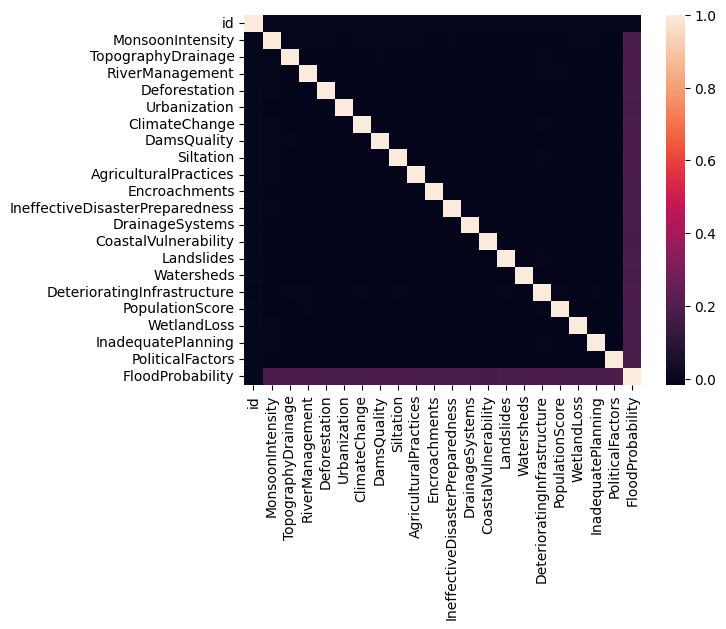

In [7]:
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix)

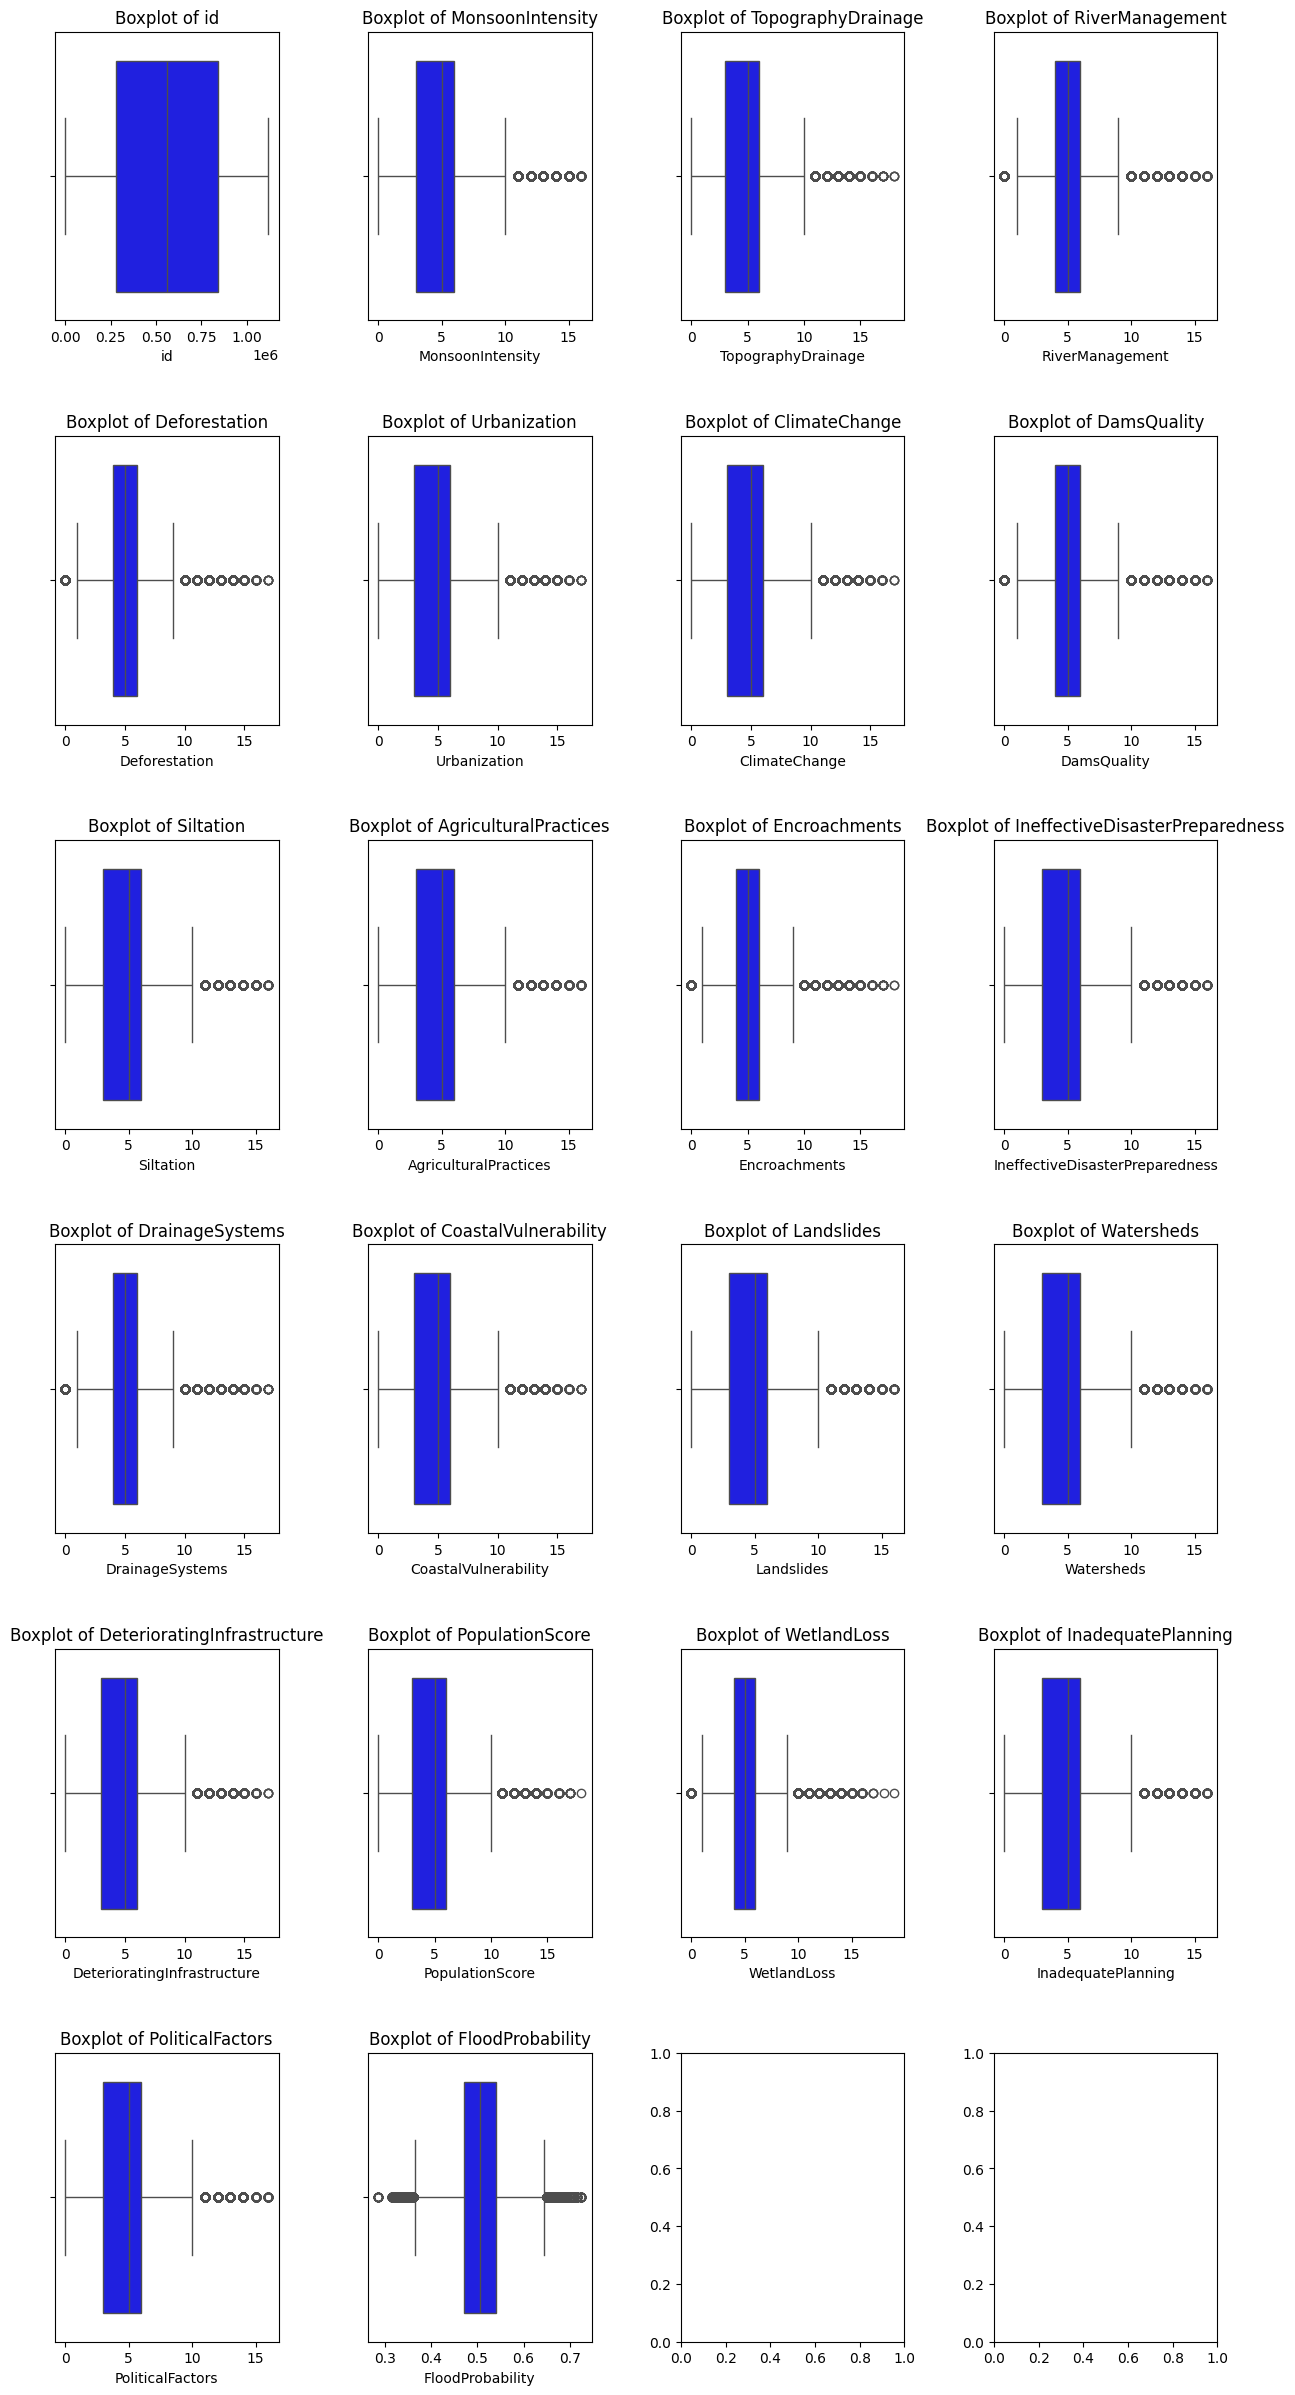

In [8]:
cols = df_train.columns.tolist()
num_cols = 4
num_rows = -(-len(cols) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()


for i, col in enumerate(cols):
    sns.boxplot(data=df_train, x=col, color="blue", ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

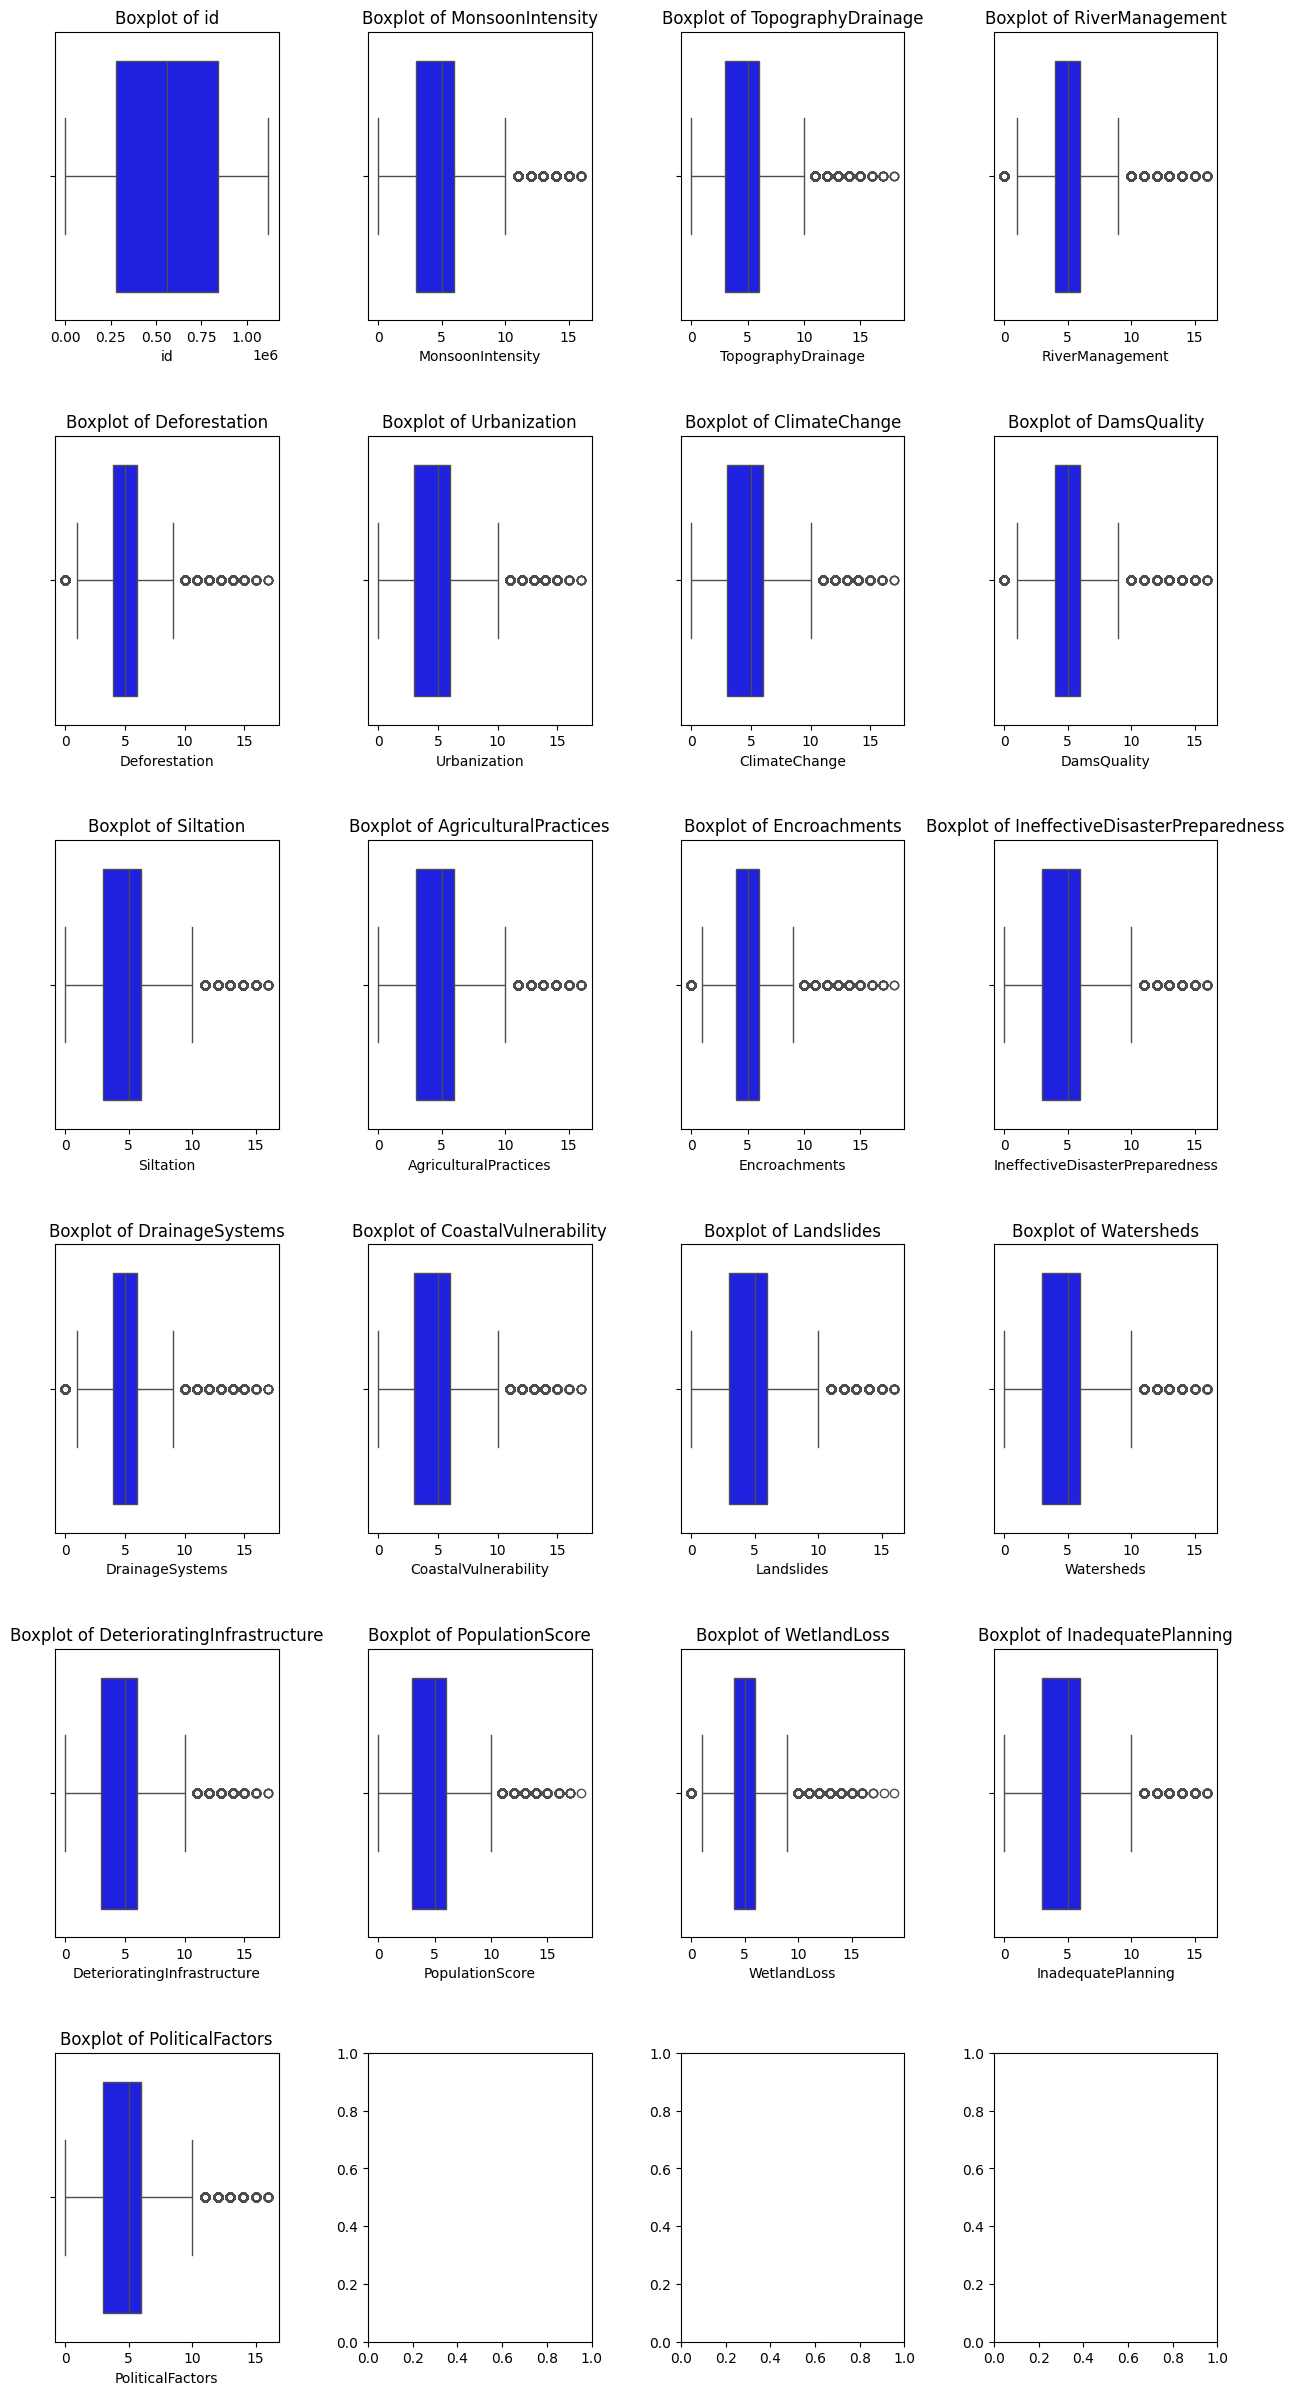

In [9]:
cols = df_test.columns.tolist()
num_cols = 4
num_rows = -(-len(cols) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()


for i, col in enumerate(cols):
    sns.boxplot(data=df_train, x=col, color="blue", ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

In [10]:
X_train = df_train.iloc[:, 1:-1]
y_train = df_train.iloc[:, -1]

In [11]:
X_test =  df_test.iloc[:, 1:]
id_test = df_test.iloc[: , 1]

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
lin_reg.score(X_train, y_train )


0.8449501050792336

In [ ]:
our_pred = lin_reg.predict(X_test)

In [ ]:
predictions_df = pd.DataFrame(our_pred, columns=['FloodProbability'])
predictions_df.head()

,FloodProbability
0,0.573615
1,0.455243
2,0.454742
3,0.466204
4,0.466068


In [ ]:
predictions_df = pd.DataFrame(our_pred, columns=['FloodProbability'])
predictions_df.head()
submission = pd.DataFrame({
    'id': sample["id"],
    'FloodProbability': our_pred
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

In [ ]:
sub = pd.read_csv("submission.csv")
sub.shape

(745305, 2)

In [ ]:
X_test.shape

(745305, 20)

works are still in progress , it was just a submision.

In [13]:
import xgboost as xg
xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)
xgb_r.fit(X_train, y_train)
xgb_r.score(X_train, y_train )

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:33:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


0.4849619376268195

0.4849619376268195

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, cross_val_score

In [ ]:
X_train, X_check, y_train, y_check = train_test_split(X_train,y_train, test_size = 0.2)
X_train.shape, y_train.shape, X_check.shape, y_check.shape

((894365, 20), (894365,), (223592, 20), (223592,))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [ ]:
X_norm = scaler.transform(X_train)
X_norm

array([[-0.93511766,  0.03448379, -0.94365558, ..., -0.46045421,
        -1.41266212, -0.92648739],
       [ 0.0372598 , -0.44291031,  0.50399906, ..., -0.94382341,
        -0.45136803,  0.98736102],
       [-0.44892893,  0.51187788,  0.02144751, ..., -1.42719262,
        -0.45136803,  0.50889892],
       ...,
       [ 0.0372598 ,  0.51187788,  0.98655061, ..., -0.46045421,
        -0.45136803, -0.44802529],
       [-0.44892893,  0.51187788,  0.50399906, ...,  0.022915  ,
        -1.41266212,  0.50889892],
       [-0.44892893, -0.44291031, -0.46110403, ..., -0.94382341,
        -0.45136803,  0.50889892]])

In [ ]:
Xt_norm = scaler.transform(X_test)
Xt_norm

array([[-0.44892893,  0.51187788, -0.94365558, ..., -0.46045421,
        -0.45136803,  0.03043682],
       [-0.44892893, -0.44291031, -1.42620712, ..., -0.46045421,
        -0.45136803, -0.92648739],
       [-1.90749513, -0.92030441,  0.50399906, ...,  0.5062842 ,
         1.47122016, -0.92648739],
       ...,
       [ 0.0372598 ,  0.98927198,  1.9516537 , ...,  0.022915  ,
         0.02927902, -0.44802529],
       [-0.44892893,  0.98927198,  0.50399906, ...,  0.98965341,
         0.02927902,  0.03043682],
       [-0.44892893, -1.3976985 ,  0.02144751, ...,  1.47302261,
         0.50992607, -0.92648739]])

In [16]:
kfold = KFold(n_splits=5, shuffle=True, random_state=69)
def model_score(model):
    scores = cross_val_score(model, X_norm, y_train, cv=kfold, scoring='r2')
    return scores.mean()

In [ ]:
model_score(lin_reg)

0.8452175180993017

In [15]:
xgb_model = xg.XGBRegressor(
    max_depth=7,
    learning_rate=0.2,
    n_estimators=400,
    reg_lambda=3.0,
    verbosity=0,
    subsample=0.8,
    colsample_bytree=0.8
)

In [ ]:
model_score(xgb_model)

0.8249538958417448

Feature Engineering

In [17]:
def feature_eng(df):
    init_feature = df.columns.tolist()
    df["sum"] = df[init_feature].sum(axis =1)
    df['std'] = df[init_feature].std(axis=1)
    df['mean'] = df[init_feature].mean(axis=1)
    df['max'] = df[init_feature].max(axis=1)
    df['min'] = df[init_feature].min(axis=1)
    df['mode'] = df[init_feature].mode(axis=1)[0]
    df['median'] = df[init_feature].median(axis=1)
    df['q_25th'] = df[init_feature].quantile(0.25, axis=1)
    df['q_75th'] = df[init_feature].quantile(0.75, axis=1)
    df['skew'] = df[init_feature].skew(axis=1)
    df['kurt'] = df[init_feature].kurt(axis=1)


In [18]:
def convert(X_train , X_test):
    X_train_converted = feature_eng(X_train)
    scaler = StandardScaler()
    scaler.fit(X_train_converted)
    X_train_norm = scaler.transform(X_train_converted)
    X_test_converted = feature_eng(X_test)
    X_test_norm = scaler.transform(X_test_converted)
    return X_train_norm , X_test_norm

kfold = KFold(n_splits=5, shuffle=True, random_state=69)
def model_score(model, X_train , X_test):
    X_train_norm, X_test_norm = convert(X_train , X_test)
    scores = cross_val_score(model, X_train_norm, y_train, cv=kfold, scoring='r2')
    return scores.mean()



In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold

def feature_eng(df):
    init_feature = df.columns.tolist()
    df["sum"] = df[init_feature].sum(axis=1)
    df['std'] = df[init_feature].std(axis=1)
    df['mean'] = df[init_feature].mean(axis=1)
    df['max'] = df[init_feature].max(axis=1)
    df['min'] = df[init_feature].min(axis=1)
    df['mode'] = df[init_feature].mode(axis=1)[0]
    df['median'] = df[init_feature].median(axis=1)
    df['q_25th'] = df[init_feature].quantile(0.25, axis=1)
    df['q_75th'] = df[init_feature].quantile(0.75, axis=1)
    df['skew'] = df[init_feature].skew(axis=1)
    df['kurt'] = df[init_feature].kurt(axis=1)
    return df

def convert(X_train, X_test):
    X_train_converted = feature_eng(X_train.copy())
    X_test_converted = feature_eng(X_test.copy())

    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train_converted)
    X_test_norm = scaler.transform(X_test_converted)

    return X_train_norm, X_test_norm

kfold = KFold(n_splits=5, shuffle=True, random_state=69)

def model_score(model, X_train, X_test, y_train):
    X_train_norm, X_test_norm = convert(X_train, X_test)
    scores = cross_val_score(model, X_train_norm, y_train, cv=kfold, scoring='r2')
    return scores.mean()


In [ ]:
#X_train_norm, X_test_norm = convert(X_train , X_test)
model_score(lin_reg, X_train , X_test , y_train)

In [ ]:
model_score(xgb_model, X_train , X_test , y_train)

In [21]:
X_train , X_test = convert(X_train, X_test)
xgb_model.fit(X_train,y_train)
our_pred = xgb_model.predict(X_test)

predictions_df = pd.DataFrame(our_pred, columns=['FloodProbability'])
predictions_df.head()
submission = pd.DataFrame({
    'id': sample["id"],
    'FloodProbability': our_pred
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

In [ ]:
def convert(X_train, X_test):
    X_train_converted = feature_eng(X_train.copy())
    X_test_converted = feature_eng(X_test.copy())

    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train_converted)
    X_test_norm = scaler.transform(X_test_converted)

    return X_train_norm, X_test_norm

kfold = KFold(n_splits=5, shuffle=True, random_state=69)

xgb_model = xg.XGBRegressor(
    max_depth=7,
    learning_rate=0.2,
    n_estimators=400,
    reg_lambda=3.0,
    verbosity=0,
    subsample=0.8,
    colsample_bytree=0.8
)

def eval_model(model, X_train, X_test, y_train):
    X_train_norm, X_test_norm = convert(X_train, X_test)
    model.fit(X_train_norm,y_train)
    our_pred = lin_reg.predict(X_test_norm)
    score = model.score(X_train, y_train )
    return score, our_pred




